In [1]:
%matplotlib inline

import os
import numpy as np
from matplotlib import pyplot as plt

from skimage import exposure
from skimage import io
from skimage import measure
from skimage import transform
from skimage import filters
from skimage import color

from scipy import ndimage

from module import threshold
from module import components
from module import contour
from module import box

In [2]:
def _draw_image(image, _plt, args=dict()):
    _plt.axis('off')
    _plt.imshow(image, **args)

def _otsu_global(image, _plt,  blur=2, plot=True):
    image = ndimage.uniform_filter(image, size=blur)
    thresholder = threshold.Threshold(image)
    umbral = thresholder.compute_global_otsu()
    image = (image > umbral).astype(np.uint8)
    if plot:
        _draw_image(image, _plt, args=dict(cmap='gray'))
    return image

def _local_treshold(image, _plt, block=65, offset=3, blur=2, plot=True):
    image = ndimage.uniform_filter(image, size=blur)
    umbral = filters.threshold_local(image, block, offset=offset)
    image = (image > umbral).astype(np.uint8)
    
    if plot:
        _draw_image(image, _plt, args=dict(cmap='gray'))
    
    return image

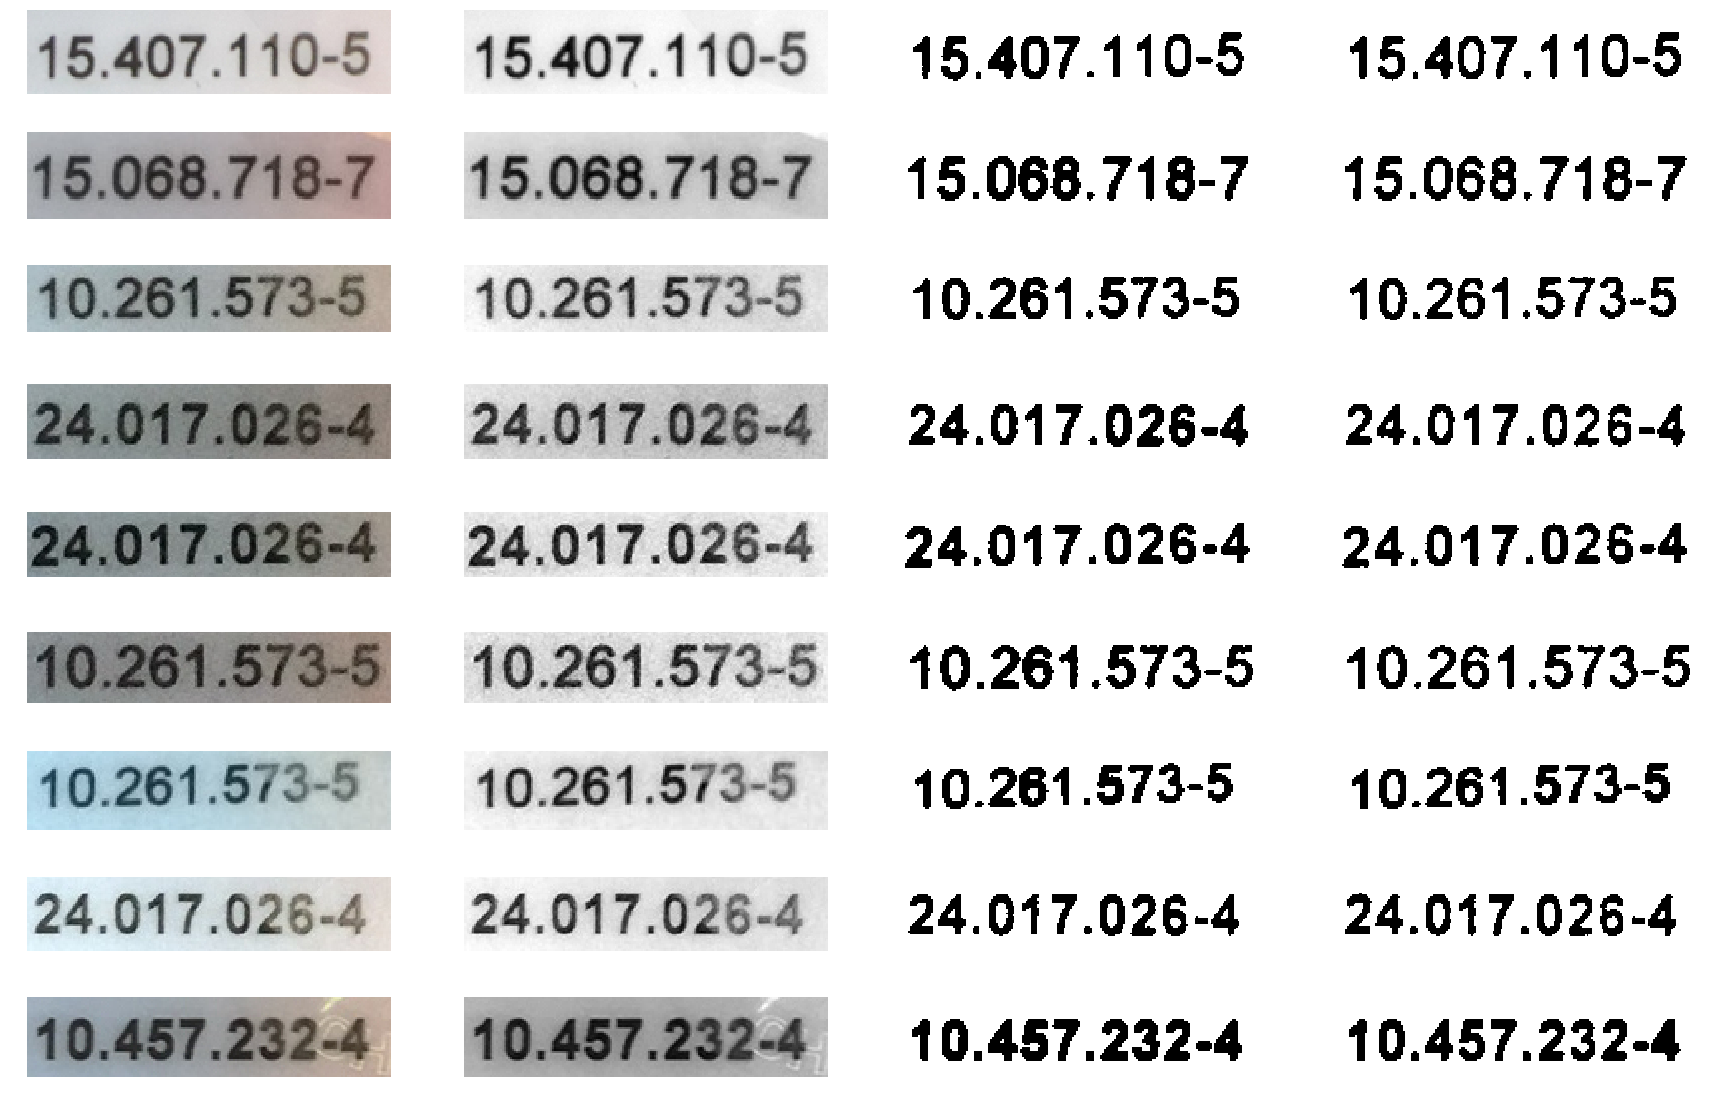

In [3]:

folder_root = 'samples'
samples = os.listdir(folder_root)
image_collections = list()

fig, axis = plt.subplots(samples.__len__(), 4, figsize=(30, 20))

for i, sample in enumerate(samples):
    path_sample = '{}{}{}'.format(folder_root, os.sep, sample)
    image = io.imread(path_sample)
    _image = color.rgb2gray(image)
    
    _draw_image(image, axis[i, 0])
    _draw_image(_image, axis[i, 1], args=dict(cmap='gray'))
    
    _otsu_filter = _otsu_global(_image, axis[i, 2])
    _local_filter = _local_treshold(_image, axis[i, 3], offset=0.1)
    raw = dict(color=image, gray=_image, otsu=_otsu_filter, local=_local_filter)
    image_collections.append(raw)

In [25]:
%%time
# Extracting Components
global_image_selected = 2

_image = image_collections[global_image_selected].get('otsu')
connectivity_searcher = components.Components(_image)
connected_components = connectivity_searcher.get()


Wall time: 54.9 ms


In [26]:
%%time
# generate bounding box
bounder_box = box.BoundBox(_image, connected_components)
box_connected_components = bounder_box.get()

Wall time: 4.99 ms


Wall time: 14 ms


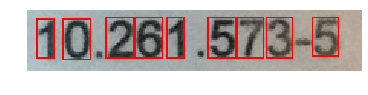

In [27]:
%%time
# drawing bounding box
image_color = image_collections[global_image_selected].get('color').copy()

bound_box_drawer = box.BoundBoxDraw(
    image_color, bounder_box.components_coordinates.values()
)

_draw_image(bound_box_drawer.draw([255, 0, 0]), plt)

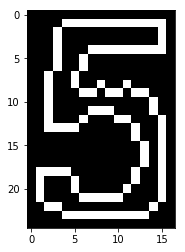

In [28]:
component = box_connected_components.get(8)
_contour = contour.ContourDetection(component)
new_image = np.zeros(shape=component.shape)
for coordinates in _contour.get():
    new_image[coordinates] = 1

plt.imshow(new_image, cmap='gray')

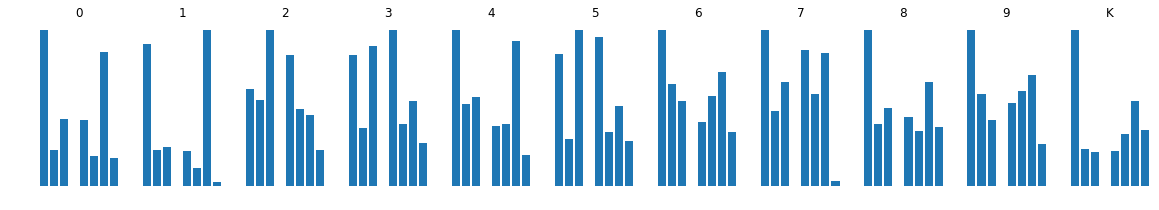

In [29]:
def get_features_from_samples(root, files):
    
    sample_features = list()
    
    for image in files:
        
        file_name = '{}{}{}'.format(root, os.sep, image)
        image = io.imread(file_name)        
        image = _otsu_global(image, None,  plot=False)
        image = np.pad(image, pad_width=1, 
                       mode='constant', constant_values=1)
        _contour = contour.ContourDetection(image)
        sample_features.append(_contour.get_features())
        
    return np.array(sample_features).mean(axis=0)

label, clasess = list(), dict()

for i, (root, dirs, files) in enumerate(os.walk('models')):
    if dirs:
        label = dirs
    else:
        clasess.__setitem__(
            label[i-1], get_features_from_samples(root, files)
        )

fig, axis = plt.subplots(1, clasess.__len__(), figsize=(20, 3))
for i, (k, v) in enumerate(clasess.items()):
    axis[i].axis('off')
    axis[i].set_title(k)
    axis[i].bar(range(len(v)), v)

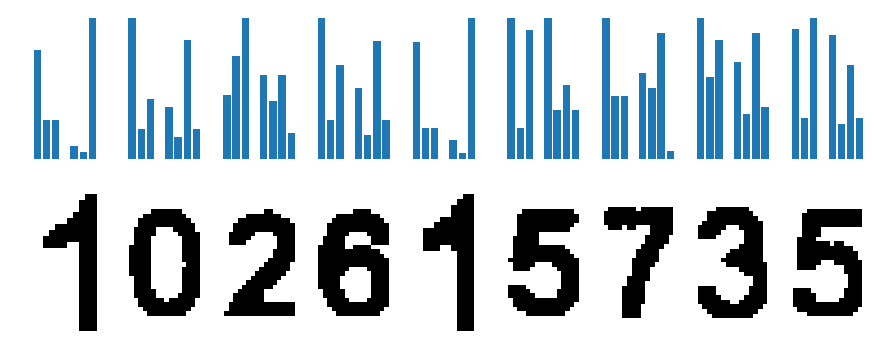

In [30]:
fig, axis = plt.subplots(2, box_connected_components.__len__(), figsize=(15, 6))

for i, (key, _image) in enumerate(box_connected_components.items()):
    _contour = contour.ContourDetection(_image)
    features = _contour.get_features()
    axis[0, i].axis('off')
    axis[0, i].bar(range(len(features)), features)
    
    _draw_image(_image, axis[1, i], args=dict(cmap='gray'))

In [31]:
result = list()

for k, _image in box_connected_components.items():
    
    comparations = list()
    _contour = contour.ContourDetection(_image)
    
    for sample_model in clasess.values():
        
        features = _contour.get_features()
        distance = np.linalg.norm(features - sample_model)
        comparations.append(distance)
    min_value = list(clasess.keys())[np.argmin(comparations)]
    result.append(min_value)

''.join(result)

'102015785'